# Raport 5
## Taiwan Banks

### Imports

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
import itertools
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot, PredictionError
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
warnings.simplefilter(action='ignore', category=FutureWarning)

### data loading

In [133]:
df = pd.read_csv('https://github.com/kflisikowski/ds/blob/master/Real%20estate.csv?raw=true')
df.rename(columns={'house age': 'age', 'distance to the nearest MRT station': 'distance', 'house price of unit area': 'price', 'number of convenience stores': 'stores'}, inplace=True)


,No,age,distance,stores,latitude,longitude,price
0,1,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,5.0,390.56840,5,24.97937,121.54245,43.1


### Missing values

In [134]:
missing_values = df.isnull().sum()

print(missing_values)

No           0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64


It's fine ;)


## Descriptive statistics

### Heatmap

Lets create heatmap to have a quick look what variables may be worth investigating

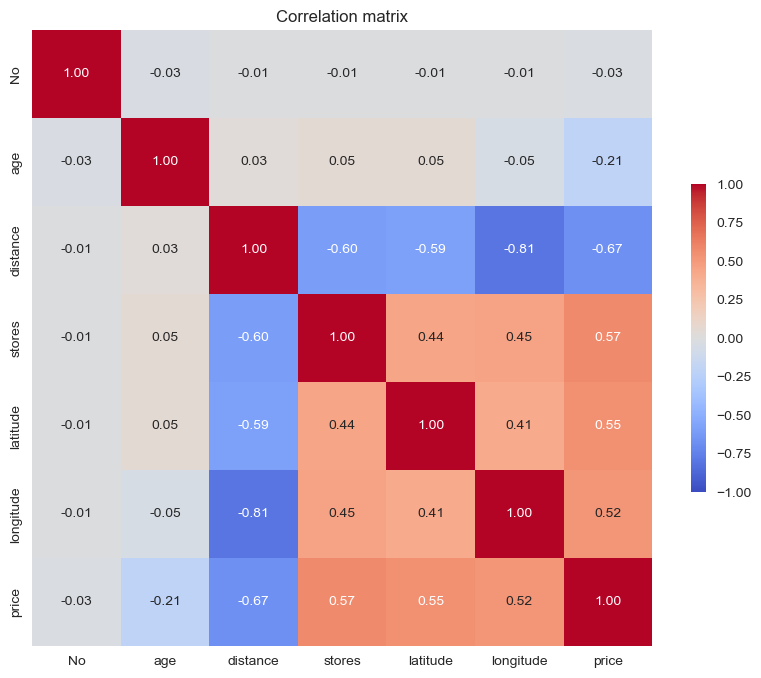

In [135]:
sns.set_style("dark")
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            annot_kws={'size': 10}, fmt='.2f', cbar_kws={'shrink': 0.5})

plt.title("Correlation matrix")
plt.show()

From corellation matrix we can see good candidates are:
- stores
- distance

Let's take a closer look

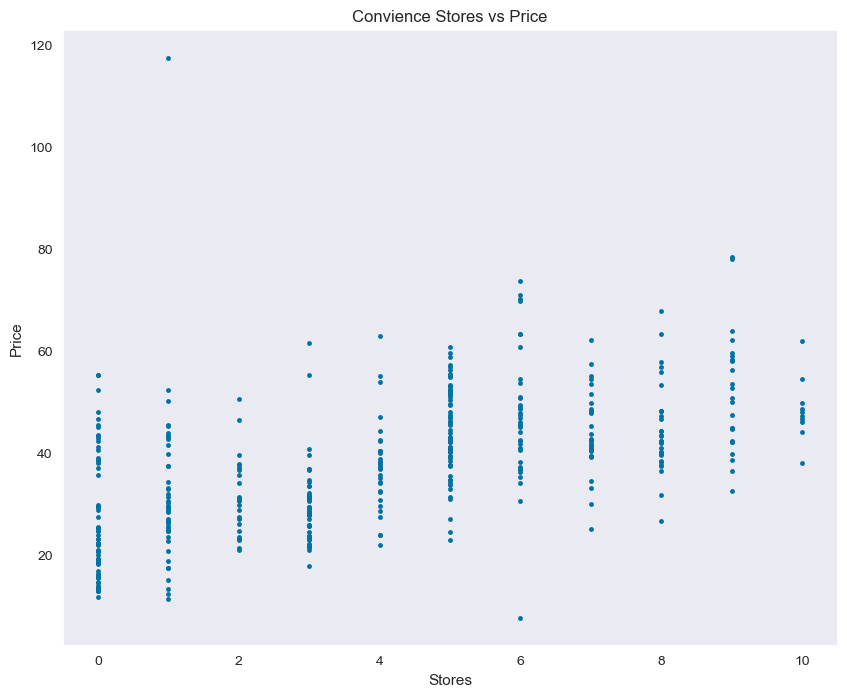

In [136]:
plt.figure(figsize=(10, 8))
plt.plot(df['stores'], df['price'],marker='.', linestyle='None')
plt.title("Convience Stores vs Price")
plt.xlabel('Stores')
plt.ylabel('Price')
plt.show()

We see possible low-moderate upward tendency

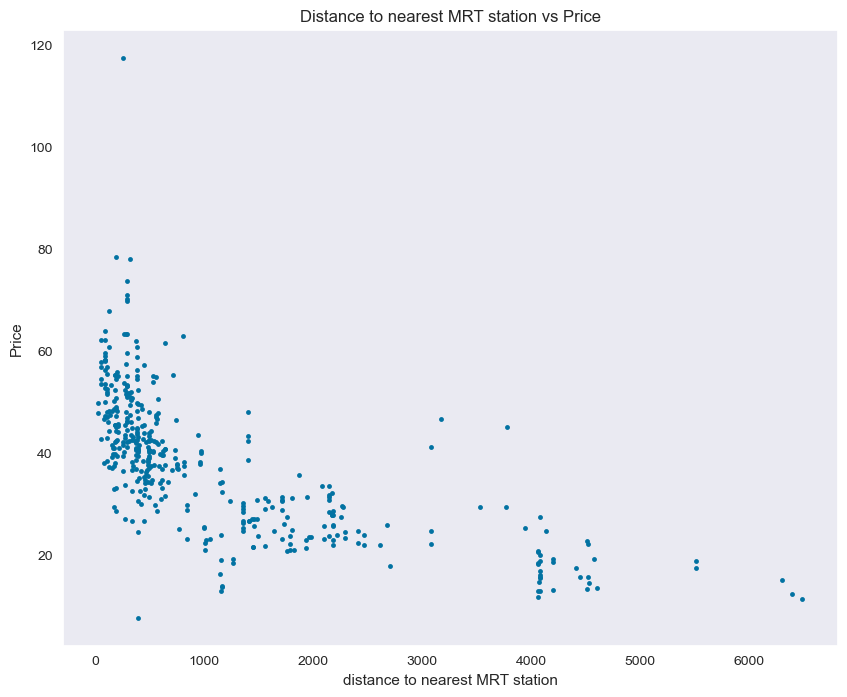

In [137]:
plt.figure(figsize=(10, 8))
plt.plot(df['distance'], df['price'],marker='.', linestyle='None')
plt.title("Distance to nearest MRT station vs Price")
plt.xlabel('distance to nearest MRT station')
plt.ylabel('Price')
plt.show()

Hmm, now points form something similar to exponential function meaning there surely is correlation between those two but its rather not linear

### Age as categorical
Lets group properties into 3 age categories and see those scattershot with differentiation to age groups

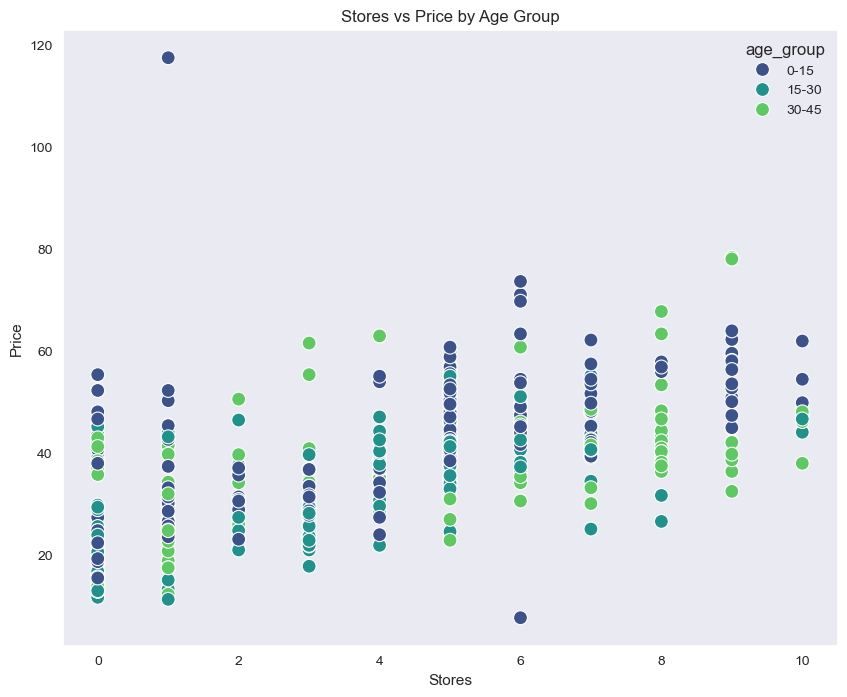

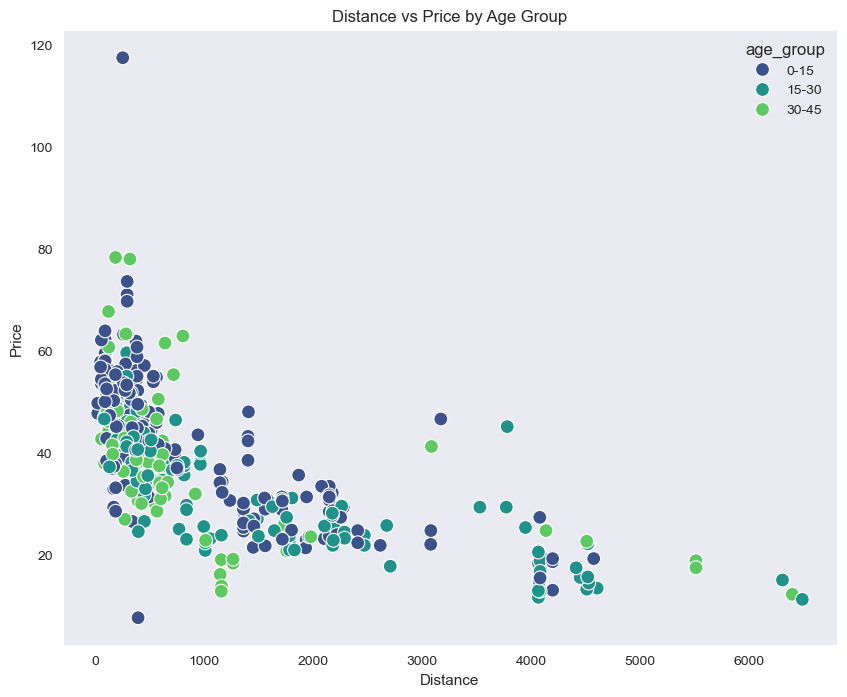

In [138]:
bins = [0, 15, 30, 45]

labels = ['0-15', '15-30', '30-45']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False, include_lowest=True)

plt.figure(figsize=(10, 8))

sns.scatterplot(data=df, x='stores', y='price', hue='age_group', palette='viridis', s=100)

plt.xlabel('Stores')
plt.ylabel('Price')
plt.title('Stores vs Price by Age Group')

plt.show()

plt.figure(figsize=(10, 8))

sns.scatterplot(data=df, x='distance', y='price', hue='age_group', palette='viridis', s=100)

plt.xlabel('Distance')
plt.ylabel('Price')
plt.title('Distance vs Price by Age Group')

plt.show()

I dont think it helped as somehow...

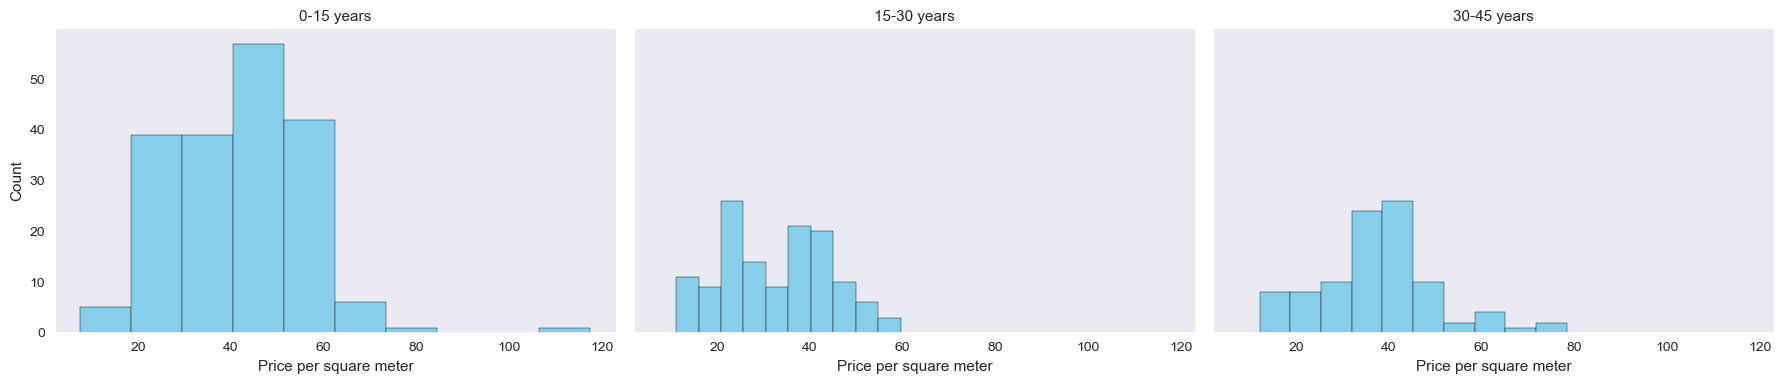

In [139]:
g = sns.FacetGrid(df, col='age_group', col_wrap=3, height=4, aspect=1.5)

g.map(plt.hist, 'price', bins=10, color='skyblue', edgecolor='black')

g.set_axis_labels('Price per square meter', 'Count')
g.set_titles(col_template='{col_name} years')


plt.tight_layout()


plt.show()

Now we can see that number of houses in each group differ a lot which may have influence on our general view. Lets take a closer look

In [140]:
summary_stats = df.groupby('age_group')['price'].agg(['mean', 'std', 'median', 'min', 'max', 'count'])


print(summary_stats)

                mean        std  median   min    max  count
age_group                                                  
0-15       41.766842  14.164308   42.55   7.6  117.5    190
15-30      32.642636  11.398217   32.90  11.2   59.6    129
30-45      37.654737  12.842547   38.30  12.2   78.3     95


Okay, now we have clear view and we can confirm that those 3 groups differ a lot.

## Simple regression model

I think the best predictor will be number of convenience stores, because as we saw on scatter plots correlation seems to be linear

Lets create simple linear regression model:

First function to plot separate plots inside FacetGrid

In [141]:
def fit_and_plot(data, **kwargs):
    x = data['stores']
    y = data['price']

    coefficients = np.polyfit(x, y, 1)

    plt.scatter(x, y, **kwargs)  # **kwargs is used here

    plt.plot(x, np.polyval(coefficients, x), color='red')

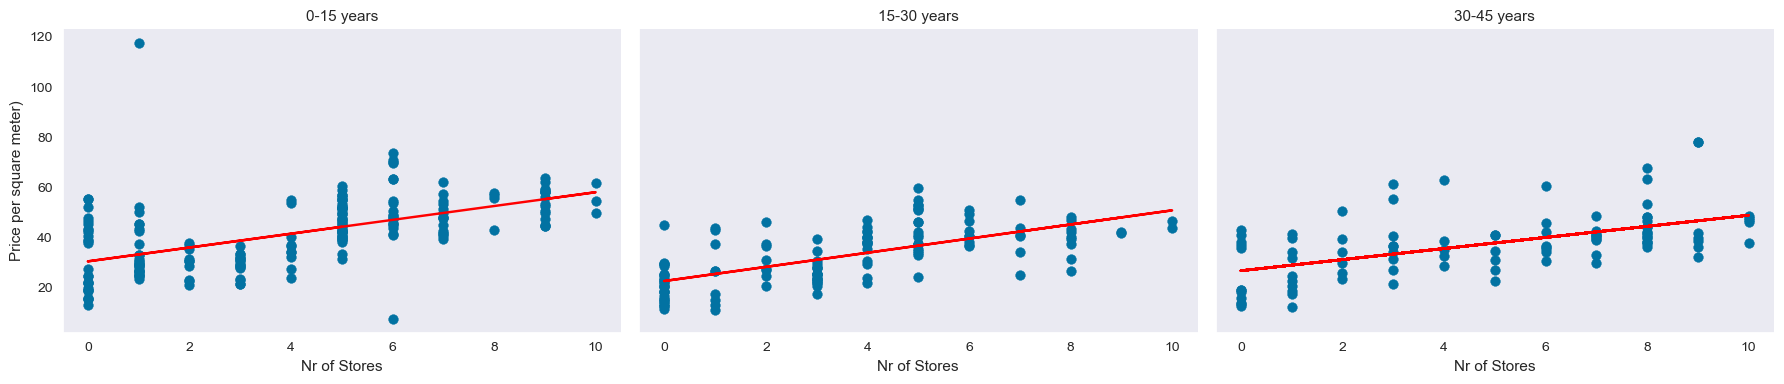

In [142]:



g = sns.FacetGrid(df, col='age_group', col_wrap=3, height=4, aspect=1.5)


g.map_dataframe(fit_and_plot)


g.set_axis_labels('Nr of Stores', 'Price per square meter)')
g.set_titles(col_template='{col_name} years')


plt.tight_layout()

plt.show()

Yeah... Now models looks pretty simillar so for the simplicity of the report lets do not differentiate between age groups

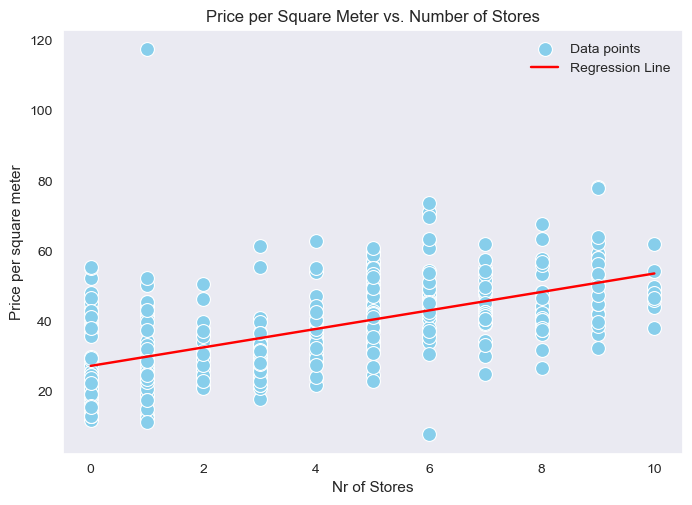

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     199.3
Date:                Mon, 10 Jun 2024   Prob (F-statistic):           3.41e-37
Time:                        22:26:03   Log-Likelihood:                -1586.0
No. Observations:                 414   AIC:                             3176.
Df Residuals:                     412   BIC:                             3184.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.1811      0.942     28.857      0.0

In [143]:
X = df['stores']
y = df['price']

X = np.array(X).reshape(-1, 1)

X = sm.add_constant(X)


model = sm.OLS(y, X).fit()


X_pred = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
X_pred = sm.add_constant(X_pred)
Y_pred = model.predict(X_pred)

sns.scatterplot(data=df, x='stores', y='price', color='skyblue',label='Data points', s=100)


plt.plot(X_pred[:, 1],Y_pred, color='red', label='Regression Line')


plt.xlabel('Nr of Stores')
plt.ylabel('Price per square meter')
plt.title('Price per Square Meter vs. Number of Stores')
plt.legend()
plt.show()


print(model.summary())

R-squared =0.326 - 32.6% of the variance in the dependent variable (price). Thats pretty low unfortunately
High F-statistic - model is statistically significant

Lets do it also for distance:

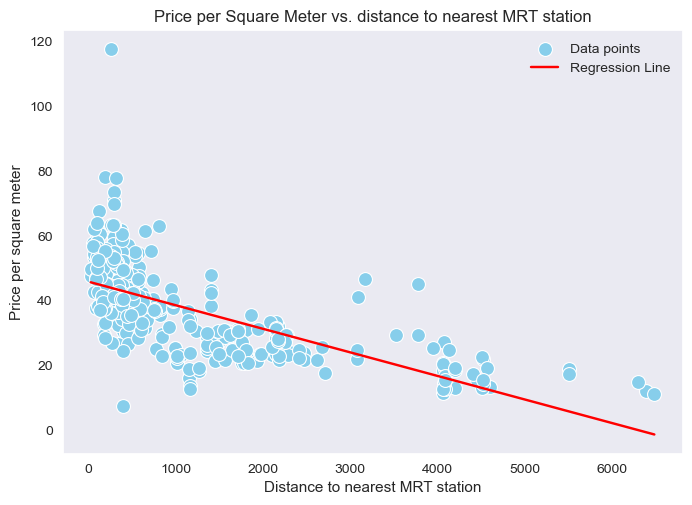

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     342.2
Date:                Mon, 10 Jun 2024   Prob (F-statistic):           4.64e-56
Time:                        22:26:03   Log-Likelihood:                -1542.5
No. Observations:                 414   AIC:                             3089.
Df Residuals:                     412   BIC:                             3097.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.8514      0.653     70.258      0.0

In [144]:
X = df['distance']
y = df['price']

X = np.array(X).reshape(-1, 1)
X = sm.add_constant(X)


model = sm.OLS(y, X).fit()


X_pred = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
X_pred = sm.add_constant(X_pred)
Y_pred = model.predict(X_pred)

sns.scatterplot(data=df, x='distance', y='price', color='skyblue',label='Data points', s=100)


plt.plot(X_pred[:, 1],Y_pred, color='red', label='Regression Line')


plt.xlabel('Distance to nearest MRT station')
plt.ylabel('Price per square meter')
plt.title('Price per Square Meter vs. distance to nearest MRT station')
plt.legend()
plt.show()


print(model.summary())

Now we see that R-squared is bigger - 0.454 which is better that previous model but we can see that relation surely isn't linear

### Diagnostic
Lets look closer on the first (stores) model

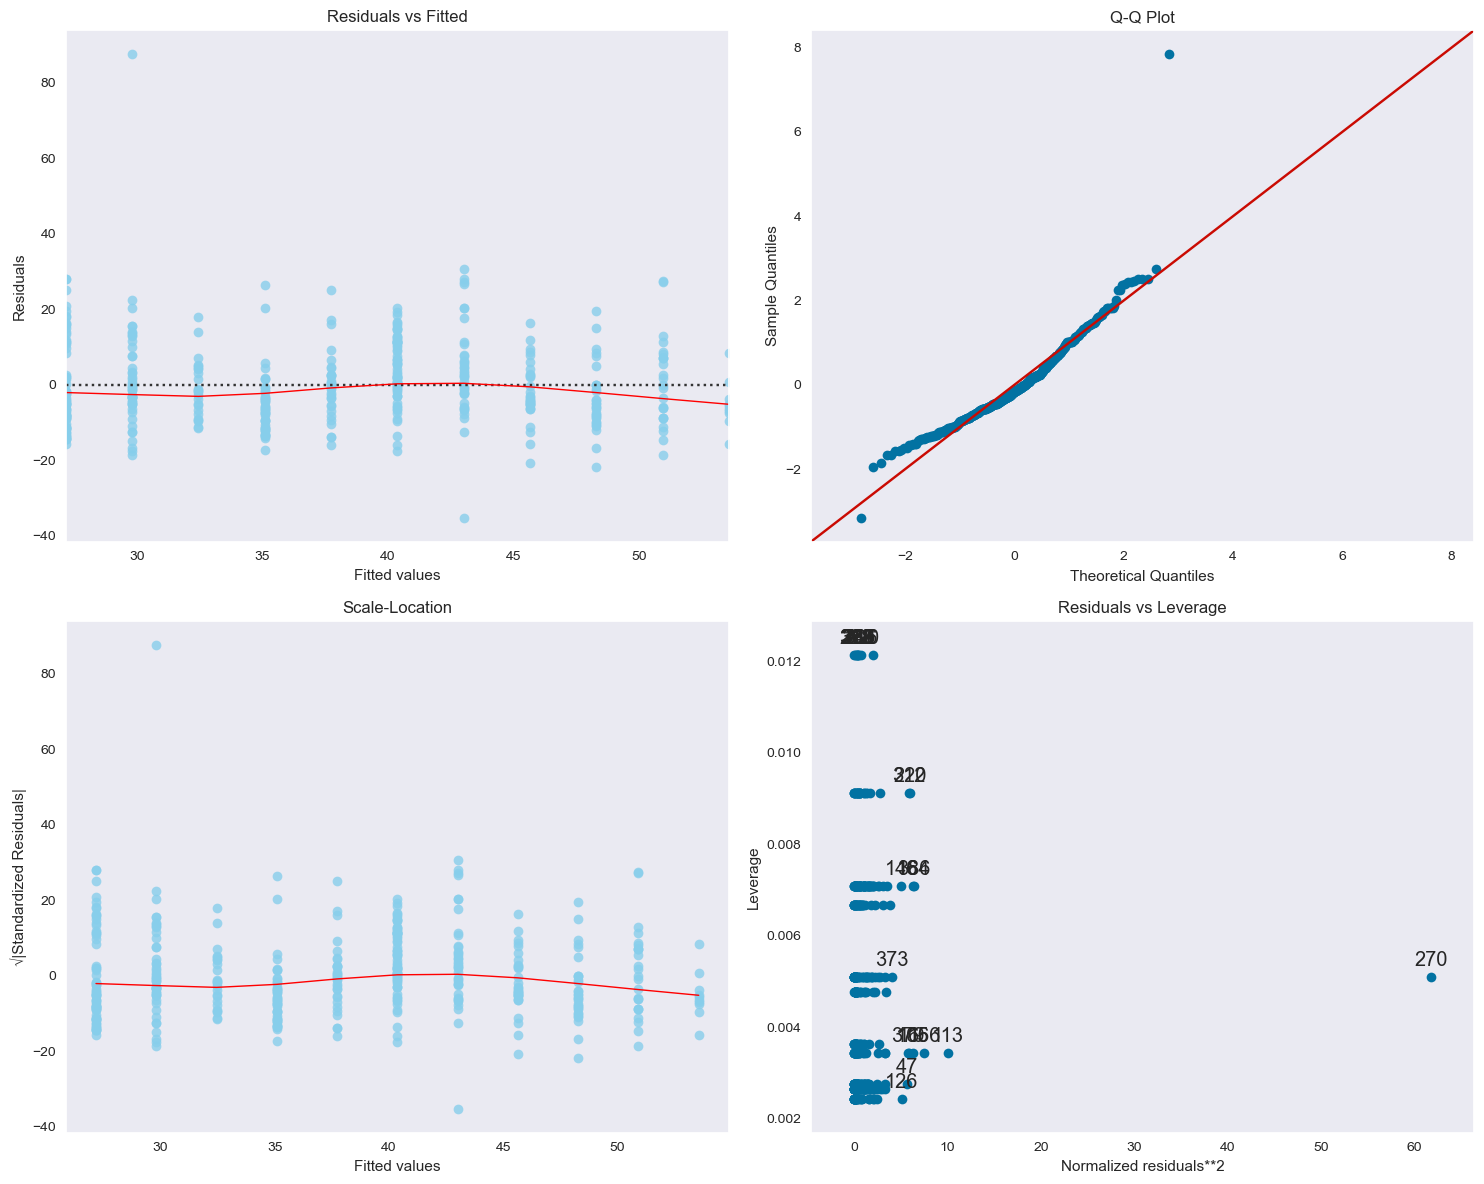

In [145]:

model = smf.ols('price ~ stores',data = df).fit()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Residuals vs Fitted
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, ax=axs[0, 0],
              line_kws={'color': 'red', 'lw': 1}, scatter_kws={'alpha': 0.8, 'color':'skyblue'})
axs[0, 0].set_title('Residuals vs Fitted')
axs[0, 0].set_xlabel('Fitted values')   
axs[0, 0].set_ylabel('Residuals')

# Q-Q Plot
sm.qqplot(model.resid, line='45',fit=True,ax=axs[0, 1],)
axs[0, 1].set_title('Q-Q Plot')

# Scale-Location Plot
modl_norm_residuals = model.get_influence().resid_studentized_internal
model_norm_res_sqrt = np.sqrt(np.abs(modl_norm_residuals))
sns.regplot(x=model.fittedvalues, y=model.resid, lowess=True, ax=axs[1, 0],ci=None,line_kws={'color': 'red', 'lw': 1},scatter_kws={'color':'skyblue'})
axs[1, 0].set_title('Scale-Location')
axs[1, 0].set_xlabel('Fitted values')
axs[1, 0].set_ylabel('√|Standardized Residuals|')

# Residuals vs Leverage Plot
from statsmodels.graphics.regressionplots import plot_leverage_resid2
plot_leverage_resid2(model, ax=axs[1, 1])
axs[1, 1].set_title('Residuals vs Leverage')

plt.tight_layout()
plt.show()


Okay now we can say somthing about how well is our model.

#### Plot 1 - Reisduals vs fitted
The residuals appear to be randomly scattered around the dotted line -> there is no major violation of the linearity assumption.
A slight curve in the red smoothing line -> potential non-linearity. (Maybe it is not perfectly linear)
#### Plot 2 - Q-Q Plot
When it come to qqplot we it is generally not so bad, but there are huge differences from teoretical line at the bwgining and at the ends -> may indicate outliers

#### Plot 3 - Scale Plot
Similar as first one indicates no major violation of the linearity assumption.
We dont se major violation of the homoscedasticity assumption.
#### Plot 4 - Scale Plot
We cas see that there exists influenical poinst for example one labeled "270":

## Multiple Regression model

### Dividing data test and train

In [146]:
X = df[['distance', 'stores','age']]
y = df['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_all= sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_all).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     115.6
Date:                Mon, 10 Jun 2024   Prob (F-statistic):           4.88e-51
Time:                        22:26:05   Log-Likelihood:                -1216.7
No. Observations:                 331   AIC:                             2441.
Df Residuals:                     327   BIC:                             2457.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.5149      1.620     26.865      0.0

##### Lets look at the summary:
 R-squared of 0.515 is not very high, it suggests that the model has **some** predictive power.
 
The very low p-value for the F-statistic indicates that the model is statistically significant

Comparing AIC and BIC to prevoius models we can see that it is lower what indicates that it is better model

Looking at model summary, we see that variable distance is least insignificant, so let's estimate the model without it:
**Note**
I just want to say that I think we should not throw out this variable until there is no clear reason to do it for example multicollinearity, but lets do it for sake of experiment

In [147]:
X2 = df[['stores','age']]
y2 = df['price']


X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_woutDistance= sm.add_constant(X_train)

model = sm.OLS(y_train2, X_train_woutDistance).fit()


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     115.6
Date:                Mon, 10 Jun 2024   Prob (F-statistic):           4.88e-51
Time:                        22:26:05   Log-Likelihood:                -1216.7
No. Observations:                 331   AIC:                             2441.
Df Residuals:                     327   BIC:                             2457.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.5149      1.620     26.865      0.0

We can see that now our model R-squered what means in has **lower** prediction power, also we can see that AIC and BIC is higher which means that this model is **worse** than previous. So as mentioned in note before We should not that one variable until we have problem with for example multicollinearity. Lets investiagte it now

### Multicollinearity

In [148]:


vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

   Variable       VIF
0  distance  1.525476
1    stores  2.050093
2       age  2.775991


We can see that **age** variable has the highest VIF, grater than 2 > which according to some statisticians may be too high, but not necessarily.
I think the best thing to do right now would be to come back to the idea of dividing set into age groups, but it would be time-consuming and we have a lot of exams to pass ;)

#### selecting variables

In [149]:

dependent_var = 'price'
predictor_vars = ['distance', 'stores', 'age']


X = df[predictor_vars]
y = df[dependent_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


def fit_model_and_calculate_metrics(dependent_var, predictors, X_train, y_train):
    predictors = ['const'] + predictors
    X = X_train[predictors]
    model = sm.OLS(y_train, X).fit()
    return model.aic, model.bic, model.rsquared_adj, model


all_combinations = []
for k in range(1, len(predictor_vars) + 1):
    all_combinations.extend(itertools.combinations(predictor_vars, k))


results = []
for combo in all_combinations:
    aic, bic, adj_r2, model = fit_model_and_calculate_metrics(dependent_var, list(combo), X_train, y_train)
    results.append((aic, bic, adj_r2, model, combo))


best_model = min(results, key=lambda x: x[0])


print(f"Best model with predictors: {best_model[4]}")
print(best_model[3].summary())


models_metrics = [{
    'model': ' + '.join(combo),
    'adj_r_squared': adj_r2,
    'AIC': aic,
    'BIC': bic
} for aic, bic, adj_r2, model, combo in results]




Best model with predictors: ('distance', 'stores', 'age')
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     115.6
Date:                Mon, 10 Jun 2024   Prob (F-statistic):           4.88e-51
Time:                        22:26:05   Log-Likelihood:                -1216.7
No. Observations:                 331   AIC:                             2441.
Df Residuals:                     327   BIC:                             2457.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

'\nX_test = sm.add_constant(X_test)\n\n# Predict on the test data using the best model\nbest_predictors = [\'const\'] + list(best_model[2])\nX_test_best = X_test[best_predictors]\ny_pred = best_model[1].predict(X_test_best)\n\n# Evaluate the model performance on the test data\nmse = mean_squared_error(y_test, y_pred)\nrmse = mse ** 0.5\nr2 = r2_score(y_test, y_pred)\n\nprint(f"Test RMSE: {rmse}")\nprint(f"Test R-squared: {r2}")\n'

#### Discusion

We can see that the best subset is the one containing all 3 variables

In [150]:
def forward_selection(data, response):
    initial_features = []
    remaining_features = data.columns.tolist()
    remaining_features.remove(response)
    selected_features = initial_features[:]
    
    while remaining_features:
        results = []
        for candidate in remaining_features:
            features = selected_features + [candidate]
            X = sm.add_constant(data[features])
            y = data[response]
            model = sm.OLS(y, X).fit()
            results.append((model.aic, candidate))
        
        results.sort()
        best_new_aic, best_candidate = results.pop(0)
        if selected_features:
            current_aic = sm.OLS(y, sm.add_constant(data[selected_features])).fit().aic
        else:
            current_aic = np.inf
        
        if best_new_aic < current_aic:
            remaining_features.remove(best_candidate)
            selected_features.append(best_candidate)
        else:
            break
    
    return selected_features


def backward_elimination(data, response):
    features = data.columns.tolist()
    features.remove(response)
    selected_features = features[:]
    
    while selected_features:
        results = []
        for candidate in selected_features:
            features = selected_features[:]
            features.remove(candidate)
            X = sm.add_constant(data[features])
            y = data[response]
            model = sm.OLS(y, X).fit()
            results.append((model.aic, candidate))
        
        results.sort(reverse=True)
        worst_new_aic, worst_candidate = results.pop(0)
        current_aic = sm.OLS(y, sm.add_constant(data[selected_features])).fit().aic
        
        if worst_new_aic < current_aic:
            selected_features.remove(worst_candidate)
        else:
            break
    
    return selected_features

In [151]:
response_var = 'price'
predictor_vars = ['distance', 'stores', 'age']

X = df[predictor_vars]
y = df[response_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)

# Perform forward selection
selected_features_forward = forward_selection(train_data, response_var)
print(f"Selected features by forward selection: {selected_features_forward}")

# Perform backward elimination
selected_features_backward = backward_elimination(train_data, response_var)
print(f"Selected features by backward elimination: {selected_features_backward}")

Selected features by forward selection: ['distance', 'age', 'stores']
Selected features by backward elimination: ['distance', 'stores', 'age']


Again we see that the best model is one containing all 3 variables.

#### Comparing models
Lest now compare model with all possible variables subsets created in bestsubset method

In [152]:
models_metrics_df = pd.DataFrame(models_metrics)
print("\nAll Models Metrics:")
print(models_metrics_df)


All Models Metrics:
                     model  adj_r_squared          AIC          BIC
0                 distance       0.429933  2489.731623  2497.335860
1                   stores       0.305088  2555.280106  2562.884343
2                      age       0.042998  2661.206941  2668.811178
3        distance + stores       0.466365  2468.864275  2480.270630
4           distance + age       0.466411  2468.835697  2480.242052
5             stores + age       0.361879  2528.052420  2539.458775
6  distance + stores + age       0.510191  2441.488321  2456.696794


We see that the best variable subset is one containing all 3 variables (Highest adj_sqrd and lowest AIC and BIC).

#### Testing

Now we can test our "best" model.
I've wrote best in quotation marks because honestly speaking it still not so good model but it is because we are limited to use only linear models
Lets see how it handles test subset

In [160]:
from sklearn.metrics import mean_squared_error, r2_score

X_test = sm.add_constant(X_test)

best_predictors = ['const'] + list(best_model[4])
X_test_best = X_test[best_predictors]
y_pred = best_model[3].predict(X_test_best)
 
 
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
 
print(f"Test RMSE: {rmse}")
print(f"Test R-squared: {r2}")


Test RMSE: 7.673868078735505
Test R-squared: 0.6489726933106557


#### Final Results comment

So here they are our final results. WHat we can say about them?

Our model has a moderately strong fit with an R-squared of 0.649, indicating that it explains around 65% of the variability in the outcome variable.

Our RMSE is 7.674 which in our dataset means 7.674 New Taiwan Dollar (NTD) [0,23 USD] / ping [3.3 m2] which seams to be really small error ;)
